In [1]:
import pandas as pd
import math
import numpy as np
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import preprocessing, svm, neighbors
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
#import tensorflow_addons as tfa

2023-08-16 16:00:46.312626: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-16 16:00:46.318769: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /N/soft/rhel7/netcdf_c/intel/serial/4.4.1.1/lib:/N/soft/rhel7/curl/intel/7.54.0/lib:/N/soft/rhel7/hdf5/intel/serial/1.10.1/lib:/N/soft/rhel7/zlib/gnu/1.2.13/lib:/N/soft/rhel7/szip/intel/2.1.1/lib:/N/soft/rhel7/libpng/1.6.29/lib:/N/soft/rhel7/jasper/gnu/1.900.1/lib:/N/soft/rhel7/openmpi/intel/4.0.1/lib:/N/soft/rhel7/intel/19.5/compilers_and_libraries_2019.5.281/linux/compiler/lib/intel64:/N/soft/rhel7/intel/19.5/compilers_and_libraries_2019.5.281/linux/ip

In [2]:
#
# build an F1-score function for later use
#
def F1_score(y_true,y_prediction,true_class,true_threshold):
    T = len(y_true)
    if len(y_prediction) != T:
        print("Prediction and true label arrays have different size. Stop")
        return
    P = 0
    TP = 0 
    FN = 0
    TN = 0
    FP = 0
    for i in range(T):
        if y_true[i] == true_class:
            P = P + 1       
            if y_prediction[i] >= true_threshold:
                TP += 1 
            else:
                FN += 1
        else:
            if y_prediction[i] >= true_threshold:
                FP += 1 
            else:
                TN += 1            
    N = T - P    
    F1 = 2.*TP/(2.*TP + FP + FN)
    Recall = TP/float(TP+FN)
    if TP == 0 and FP == 0: 
        Precision = 0.
    else:    
        Precision = TP/float(TP+FP)
    return F1, Recall, Precision

In [3]:
#
# reading all input data, and replace/remove bad data. Note that this data set 
# must contain the last column "class" that indicates RI (1) or non-RI (0). Note that
# option flag_input_more_time denotes a single time slice, or mutiple time slices from
# SHIP forecasts.
#
flag_input_future_time="24h"                                              # 00h, 12h, or 24h
good_input = "yes"
if flag_input_future_time == "12h":    
    df = pd.read_csv('/N/u/ckieu/Carbonate/python/SHIP_allbasin_2017_2022_Version1(+12hr).csv')       # Future up to 12h
    df.drop(['OHC','OHC(+6h)','OHC(+12h)'], axis=1, inplace=True)         # axis = 0/1 means row/col drop
elif flag_input_future_time == "24h":    
    df = pd.read_csv('/N/u/ckieu/Carbonate/python/SHIP_allbasin_2011_2022_Version3(+24hr).csv')       # Future up to 24h
    df.drop(['Storm','OHC','OHC(+6h)','OHC(+12h)',
             'OHC(+18h)','OHC(+24h)'], axis=1, inplace=True)              # axis = 0/1 means row/col drop    
elif flag_input_future_time == "00h":
    df = pd.read_csv('/N/u/ckieu/Carbonate/python/AtlanticMajorHurricane2016-2019.csv')               # Only initial cycle at 0h
    df.drop(['OHC'], axis=1, inplace=True)
else:
    print("flag_input_future_time is not correctly set. Stop")
    good_input = "no"
    
if good_input == "yes":   
    df.replace('?',-99999, inplace=True)
    print(df.head(3))
    x = np.array(df.drop(['class'],axis=1)).astype("float32")
    y = np.array(df['class']).astype("float32")
    print(x[0],y[0])
    print("The length of data frame df variable is ",len(df))

    lat    lon  MaxWind  RMW  MIN_SLP  SHR_MAG  SHR_HDG  STM_SPD  STM_HDG  \
0  28.6  282.5       44   65      994       36       86       15       59   
1  29.9  285.1       50  120      993       31       84       22       49   
2  30.9  287.5       56  163      991       34       86       23       53   

   SST  ...  SHR_HDG(+24h)  STM_SPD(+24h)  STM_HDG(+24h)  SST(+24h)  \
0  263  ...             77             21             63        257   
1  260  ...             82             23             66        248   
2  262  ...             74             27             66        231   

   TPW(+24h)  LAND(+24h)  850TANG(+24h)  850VORT(+24h)  200DVRG(+24h)  class  
0         47         635            163             20             82      0  
1         46         888            170             40             41      0  
2         43         958            175             66             47      0  

[3 rows x 76 columns]
[ 28.6 282.5  44.   65.  994.   36.   86.   15.   59.  263.   48.  

In [4]:
#
# produce a simple reference forecast by randomly sampling the y array and check how many 
# of the random_label matches the y array. That is, if y[i] = random_label_copy[y], then
# hits_array[i] = 1, else hits_array[i] = 0.
#
import copy
random_label_copy = copy.copy(y)
print(random_label_copy[0:50])
np.random.shuffle(random_label_copy)
print(random_label_copy[0:50])
hits_array = np.array(y) == np.array(random_label_copy)
#print(hits_array)
print(f"Reference forecast by random sampling the y label gives an accuracy (RI or non-RI) of: {hits_array.mean():.3f}")

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
Reference forecast by random sampling the y label gives an accuracy (RI or non-RI) of: 0.848


In [5]:
#
# Create a first simple model for RI forecast, using the logistic regression method. Note the 
# difference between "binary_accuracy" and "accuracy" metrics as mentioned in 
# https://keras.io/api/metrics/accuracy_metrics/. 
# - binary_accuracy: compare two real numbers to see if they match above a given threshold
# - accuracy: compare two integer numbers to see if they match.
# 
x1_train, x1_test, y1_train, y1_test = train_test_split(x, y, test_size=0.1)
print("Total train and test data sizes are: ", x1_train.shape,x1_test.shape,y1_train.shape,y1_test.shape)
validation_split = np.int(0.1*len(x1_train))
x2_val = x1_train[:validation_split]
y2_val = y1_train[:validation_split]
x2_train = x1_train[validation_split:]
y2_train = y1_train[validation_split:]
print("Train and validation data sizes are: ", x2_train.shape,x2_val.shape,y2_train.shape,y2_val.shape)

model_logistics = keras.Sequential([layers.Dense(32, activation = "relu"),
                                    layers.Dense(32, activation = "relu"),
                                    layers.Dense(1, activation = "sigmoid")])
#
# Two options for metrics here: accuracy or binary_accuracy
#
#model.compile(optimizer="rmsprop",loss="binary_crossentropy",metrics=["accuracy"])
callbacks = [keras.callbacks.ModelCheckpoint("RI_model_logistics_24h.keras",save_best_only=True)]
model_logistics.compile(optimizer="rmsprop",loss="binary_crossentropy",
                        metrics=[tf.keras.metrics.BinaryAccuracy(name="binary_accuracy", dtype=None, threshold=0.8)])
history_logistics = model_logistics.fit(x2_train,y2_train,epochs=50,batch_size=16,validation_data=(x2_val,y2_val),
                                       callbacks=callbacks)

Total train and test data sizes are:  (3856, 75) (429, 75) (3856,) (429,)
Train and validation data sizes are:  (3471, 75) (385, 75) (3471,) (385,)


/tmp/ipykernel_32083/3633577841.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  validation_split = np.int(0.1*len(x1_train))
2023-08-16 16:01:28.858636: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /N/soft/rhel7/netcdf_c/intel/serial/4.4.1.1/lib:/N/soft/rhel7/curl/intel/7.54.0/lib:/N/soft/rhel7/hdf5/intel/serial/1.10.1/lib:/N/soft/rhel7/zlib/gnu/1.2.13/lib:/N/soft/rhel7

Epoch 1/50
217/217 [==============================] - 1s 2ms/step - loss: 13.0208 - binary_accuracy: 0.8433 - val_loss: 3.4539 - val_binary_accuracy: 0.8883
Epoch 2/50
217/217 [==============================] - 0s 1ms/step - loss: 3.8388 - binary_accuracy: 0.8750 - val_loss: 7.3722 - val_binary_accuracy: 0.8364
Epoch 3/50
217/217 [==============================] - 0s 1ms/step - loss: 3.1933 - binary_accuracy: 0.8801 - val_loss: 0.9889 - val_binary_accuracy: 0.9013
Epoch 4/50
217/217 [==============================] - 0s 1ms/step - loss: 2.9587 - binary_accuracy: 0.8842 - val_loss: 3.8153 - val_binary_accuracy: 0.8649
Epoch 5/50
217/217 [==============================] - 0s 1ms/step - loss: 2.4031 - binary_accuracy: 0.8850 - val_loss: 2.5443 - val_binary_accuracy: 0.8468
Epoch 6/50
217/217 [==============================] - 0s 1ms/step - loss: 2.0467 - binary_accuracy: 0.8969 - val_loss: 1.5032 - val_binary_accuracy: 0.8312
Epoch 7/50
217/217 [==============================] - 0s 1ms/st

14/14 [==============================] - 0s 916us/step - loss: 0.2233 - binary_accuracy: 0.9301
Evalution results (loss,accuracy) for the test data is  [0.2233251929283142, 0.9300699234008789]
14/14 [==============================] - 0s 766us/step
F1, Recall, Precision for logistic model are: (0.37037037037037035, 0.6666666666666666, 0.2564102564102564)


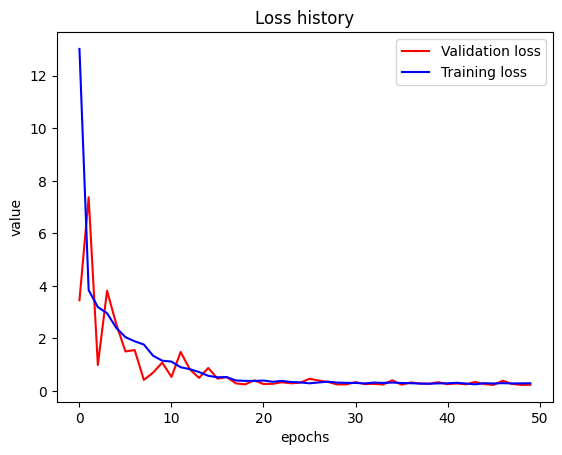

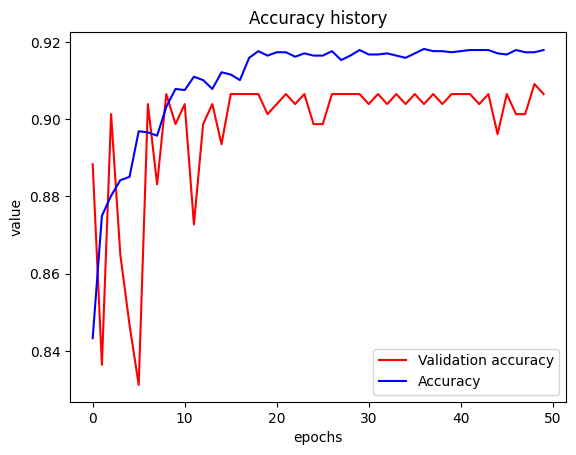

In [6]:
#
# check F1 score for the logistic model with the internal test data
#
results = model_logistics.evaluate(x1_test,y1_test)
print("Evalution results (loss,accuracy) for the test data is ",results)
single_fcst = model_logistics.predict(x1_test)
#for i in range(len(single_fcst)):
#    print(y1_test[i]," <---> RI Propbability: ",f"{float(single_fcst[i]):.5f}")
print("F1, Recall, Precision for logistic model are:",F1_score(y1_test,single_fcst,1,0.10))  
#
# plotting the performance of the logistics regression
#
import matplotlib.pyplot as plt
#print(history_logistics.__dict__)
epochs = history_logistics.epoch
val_loss = history_logistics.history['val_loss']
loss = history_logistics.history['loss']
plt.plot(epochs,val_loss,'r',label="Validation loss")
plt.xlabel("epochs")
plt.ylabel("value")
plt.title("Loss history")
plt.plot(epochs,loss,'b',label="Training loss")
plt.legend()
plt.show()

plt.clf()
val_accuracy = history_logistics.history['val_binary_accuracy']
accuracy = history_logistics.history['binary_accuracy']
plt.plot(epochs,val_accuracy,'r',label="Validation accuracy")
plt.xlabel("epochs")
plt.ylabel("value")
plt.title("Accuracy history")
plt.plot(epochs,accuracy,'b',label="Accuracy")
plt.legend()
plt.show()

In [7]:
#
# create input data for RNN by reshaping the input data into a new tensor of the dimension
# (num_sample, num_times, num_predictors). Note that using the metric=accuracy returns very bad
# accuracy < 0.1
# 
if flag_input_future_time == "24h":
    sequence_length = 5
elif flag_input_future_time == "12h":
    sequence_length = 3
elif flag_input_future_time == "00h":
    sequence_length = 1    
num_predictors = 15
print("Train/val data sizes before reshape are: ", x2_train.shape,x2_val.shape,y2_train.shape,y2_val.shape)
x3_val = x2_val.reshape((-1,sequence_length,num_predictors))
x3_train = x2_train.reshape((-1,sequence_length,num_predictors))
test_dataset = x1_test.reshape((-1,sequence_length,num_predictors))
print("New train/validation data sizes for RNN are: ", x3_train.shape,x3_val.shape, test_dataset.shape)
print(x2_val[0])
print(x3_val[0])

Train/val data sizes before reshape are:  (3471, 75) (385, 75) (3471,) (385,)
New train/validation data sizes for RNN are:  (3471, 5, 15) (385, 5, 15) (429, 5, 15)
[ 31.5 286.2  55.   78.  996.   15.  159.   12.   17.  281.   51.  444.
 119.  -21.   28.   32.6 286.6  52.  116.  996.   14.  169.   13.   23.
 281.   52.  377.  111.   -7.   16.   33.9 287.4  65.  114.  993.   10.
 191.   17.   24.  277.   52.  348.  118.  -23.   31.   35.7 288.3  86.
  64.  982.    7.  231.   20.   13.  279.   53.  379.  123.    1.   53.
  37.9 288.5  67.   81.  978.   10.  299.   19.    1.  278.   53.  303.
 131.   -5.   40. ]
[[ 31.5 286.2  55.   78.  996.   15.  159.   12.   17.  281.   51.  444.
  119.  -21.   28. ]
 [ 32.6 286.6  52.  116.  996.   14.  169.   13.   23.  281.   52.  377.
  111.   -7.   16. ]
 [ 33.9 287.4  65.  114.  993.   10.  191.   17.   24.  277.   52.  348.
  118.  -23.   31. ]
 [ 35.7 288.3  86.   64.  982.    7.  231.   20.   13.  279.   53.  379.
  123.    1.   53. ]
 [ 37.9 

In [8]:
#
# Build first an RNN model for RI prediction to see how it compares to the simple logistic regression
# model, using the newly-formatted data
#
inputs = keras.Input(shape=(sequence_length,num_predictors))
x = layers.SimpleRNN(16, return_sequences=True)(inputs)
x = layers.SimpleRNN(16, return_sequences=True)(x)
outputs = layers.SimpleRNN(1,activation = "sigmoid")(x)
model_RNN = keras.Model(inputs, outputs)

callbacks = [keras.callbacks.ModelCheckpoint("RI_model_RNN_24h.keras",save_best_only=True)]
model_RNN.compile(optimizer="rmsprop",loss="mse",
                  metrics=[tf.keras.metrics.BinaryAccuracy(name="binary_accuracy", dtype=None, threshold=0.2)])
history_RNN = model_RNN.fit(x3_train, y2_train, epochs=50, batch_size=64, 
                             validation_data=(x3_val, y2_val), callbacks=callbacks)

model_best = keras.models.load_model("RI_model_RNN_24h.keras")
print(f"The best trained RNN prediction error is: {model_best.evaluate(test_dataset,y1_test)[1]:.3f}")
print(f"The last trained RNN prediction error is: {model_RNN.evaluate(test_dataset,y1_test)[1]:.3f}")

Epoch 1/50
55/55 [==============================] - 2s 8ms/step - loss: 0.1353 - binary_accuracy: 0.7384 - val_loss: 0.0933 - val_binary_accuracy: 0.8338
Epoch 2/50
55/55 [==============================] - 0s 3ms/step - loss: 0.0789 - binary_accuracy: 0.8923 - val_loss: 0.0863 - val_binary_accuracy: 0.8909
Epoch 3/50
55/55 [==============================] - 0s 3ms/step - loss: 0.0761 - binary_accuracy: 0.9133 - val_loss: 0.0849 - val_binary_accuracy: 0.9013
Epoch 4/50
55/55 [==============================] - 0s 3ms/step - loss: 0.0756 - binary_accuracy: 0.9147 - val_loss: 0.0841 - val_binary_accuracy: 0.9013
Epoch 5/50
55/55 [==============================] - 0s 3ms/step - loss: 0.0755 - binary_accuracy: 0.9162 - val_loss: 0.0843 - val_binary_accuracy: 0.9065
Epoch 6/50
55/55 [==============================] - 0s 3ms/step - loss: 0.0752 - binary_accuracy: 0.9156 - val_loss: 0.0840 - val_binary_accuracy: 0.9065
Epoch 7/50
55/55 [==============================] - 0s 3ms/step - loss: 0.07

14/14 [==============================] - 0s 1ms/step
F1, Recall, Precision for RNN model are: (0.14655172413793102, 0.5666666666666667, 0.08415841584158416)


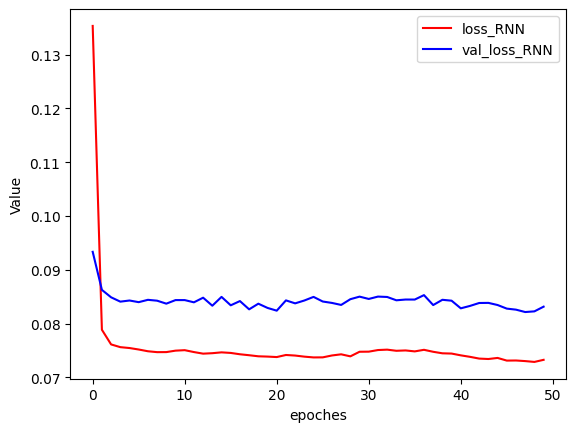

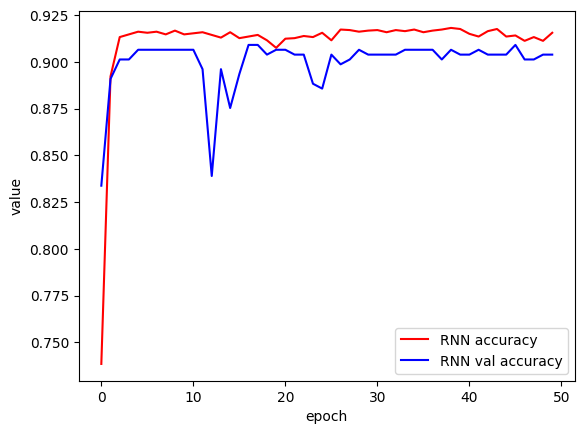

In [9]:
#
# Check F1 score now for the RNN model
#
y_prediction = model_RNN.predict(test_dataset)
#print(model_best.evaluate(test_dataset,y1_test))
#print(y_prediction[398],y1_test,len(y1_test))
print("F1, Recall, Precision for RNN model are:",F1_score(y1_test,y_prediction,1,0.07))
#
# ploting the performance of the RNN model
#
epoch = history_RNN.epoch
val_loss_RNN = history_RNN.history['val_loss'] 
loss_RNN = history_RNN.history['loss']
plt.plot(epoch,loss_RNN,'r',label="loss_RNN")
plt.xlabel("epoches")
plt.ylabel("Value")
plt.plot(epoch,val_loss_RNN,'b',label="val_loss_RNN")
plt.legend()
plt.show()

accuracy_RNN = history_RNN.history['binary_accuracy']
val_accuracy_RNN = history_RNN.history['val_binary_accuracy']
plt.plot(epoch,accuracy_RNN,'r',label="RNN accuracy")
plt.plot(epoch,val_accuracy_RNN,'b',label="RNN val accuracy")
plt.xlabel("epoch")
plt.ylabel("value")
plt.legend()
plt.show()

In [10]:
#
# Now, lets try to use GRU method to see how it performs as compared to the RNN
#
inputs = keras.Input(shape=(sequence_length,num_predictors))
x = layers.GRU(16, return_sequences=True)(inputs)
x = layers.GRU(16, return_sequences=True)(x)
outputs = layers.GRU(1,activation = "sigmoid")(x)
model_GRU = keras.Model(inputs, outputs)

callbacks = [keras.callbacks.ModelCheckpoint("RI_model_GRU_24h.keras",save_best_only=True)]
model_GRU.compile(optimizer="rmsprop",loss="mse",
                  metrics=[tf.keras.metrics.BinaryAccuracy(name="binary_accuracy", dtype=None, threshold=0.2)])
history_GRU = model_GRU.fit(x3_train, y2_train, epochs=50, batch_size=64, 
                             validation_data=(x3_val, y2_val), callbacks=callbacks)

model_best = keras.models.load_model("RI_model_GRU_24h.keras")
print(f"The best trained GRU prediction error is: {model_best.evaluate(test_dataset,y1_test)[1]:.3f}")
print(f"The last trained GRU prediction error is: {model_GRU.evaluate(test_dataset,y1_test)[1]:.3f}")

Epoch 1/50
55/55 [==============================] - 4s 17ms/step - loss: 0.0848 - binary_accuracy: 0.7672 - val_loss: 0.0850 - val_binary_accuracy: 0.9013
Epoch 2/50
55/55 [==============================] - 0s 6ms/step - loss: 0.0755 - binary_accuracy: 0.9147 - val_loss: 0.0841 - val_binary_accuracy: 0.9013
Epoch 3/50
55/55 [==============================] - 0s 6ms/step - loss: 0.0749 - binary_accuracy: 0.9141 - val_loss: 0.0835 - val_binary_accuracy: 0.9013
Epoch 4/50
55/55 [==============================] - 0s 6ms/step - loss: 0.0747 - binary_accuracy: 0.9153 - val_loss: 0.0834 - val_binary_accuracy: 0.9013
Epoch 5/50
55/55 [==============================] - 0s 5ms/step - loss: 0.0746 - binary_accuracy: 0.9159 - val_loss: 0.0837 - val_binary_accuracy: 0.9039
Epoch 6/50
55/55 [==============================] - 0s 6ms/step - loss: 0.0745 - binary_accuracy: 0.9167 - val_loss: 0.0838 - val_binary_accuracy: 0.9039
Epoch 7/50
55/55 [==============================] - 0s 6ms/step - loss: 0.0

14/14 [==============================] - 1s 2ms/step
F1, Recall, Precision for GRU model are: (0.17454545454545456, 0.8, 0.09795918367346938)


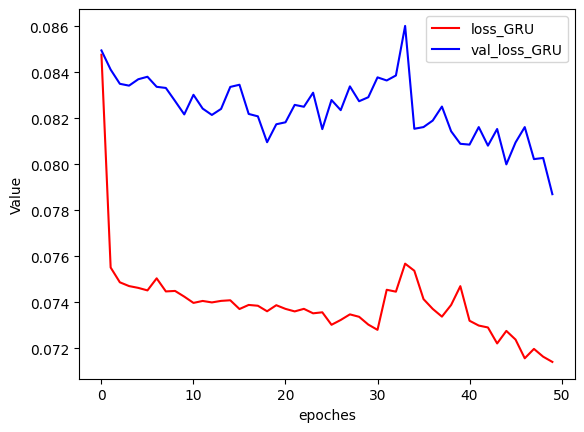

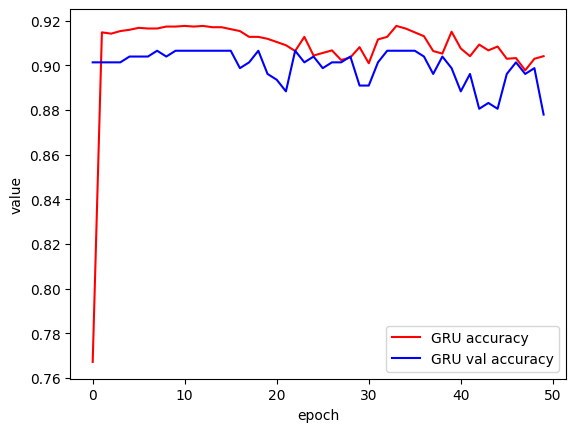

In [11]:
#
# Check F1 score now for the GRU model
#
y_prediction = model_GRU.predict(test_dataset)
print("F1, Recall, Precision for GRU model are:",F1_score(y1_test,y_prediction,1,0.07))
#
# ploting the performance of the RNN model
#
epoch = history_GRU.epoch
val_loss_GRU = history_GRU.history['val_loss'] 
loss_GRU = history_GRU.history['loss']
plt.plot(epoch,loss_GRU,'r',label="loss_GRU")
plt.xlabel("epoches")
plt.ylabel("Value")
plt.plot(epoch,val_loss_GRU,'b',label="val_loss_GRU")
plt.legend()
plt.show()

accuracy_GRU = history_GRU.history['binary_accuracy']
val_accuracy_GRU = history_GRU.history['val_binary_accuracy']
plt.plot(epoch,accuracy_GRU,'r',label="GRU accuracy")
plt.plot(epoch,val_accuracy_GRU,'b',label="GRU val accuracy")
plt.xlabel("epoch")
plt.ylabel("value")
plt.legend()
plt.show()

In [16]:
#
# loading three different pre-trained models using all 24-h input SHIP data
#
df = pd.read_csv('/N/u/ckieu/Carbonate/python/DOKSURI05W_Master.csv')
df.drop(['Time','Basin','OHC','OHC(+6h)','OHC(+12h)','OHC(+18h)','OHC(+24h)'], axis=1, inplace=True)
df.replace('?',-99999, inplace=True)
x_fcst = np.array(df.drop(['Storm','class'],axis=1))
y_true = np.array(df['class'])
x_tlag = x_fcst.reshape((-1,sequence_length,num_predictors))
print('External input SHIP data length is: ',len(x_fcst))
#print(x_fcst[0])
print(y_true)
model_RNN_1d = keras.models.load_model("RI_model_RNN_24h.keras")
model_logistics_1d = keras.models.load_model("RI_model_logistics_24h.keras")
model_GRU_1d = keras.models.load_model("RI_model_GRU_24h.keras")
fcst_logistics_1d = model_logistics_1d.predict(x_fcst)
fcst_GRU_1d = model_GRU_1d.predict(x_tlag)
fcst_RNN_1d = model_RNN_1d.predict(x_tlag)
for i in range(len(x_fcst)):
    print(f"Logistic, RNN, GRU probability predictions: {float(fcst_logistics_1d[i]):.3f},{float(fcst_RNN_1d[i]):.3f},{float(fcst_GRU_1d[i]):.3f}")
print("F1, Recall, Precision for logistics model are:",F1_score(y_true,fcst_logistics_1d,1,0.3))    
print("F1, Recall, Precision for RNN model are:",F1_score(y_true,fcst_RNN_1d,1,0.3))    
print("F1, Recall, Precision for GRU model are:",F1_score(y_true,fcst_GRU_1d,1,0.3))    

External input SHIP data length is:  24
[1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
1/1 [==============================] - 0s 234ms/step
Logistic, RNN, GRU probability predictions: 0.445,0.057,0.350
Logistic, RNN, GRU probability predictions: 0.445,0.057,0.350
Logistic, RNN, GRU probability predictions: 0.445,0.057,0.284
Logistic, RNN, GRU probability predictions: 0.445,0.057,0.068
Logistic, RNN, GRU probability predictions: 0.469,0.057,0.068
Logistic, RNN, GRU probability predictions: 0.475,0.056,0.303
Logistic, RNN, GRU probability predictions: 0.351,0.084,0.197
Logistic, RNN, GRU probability predictions: 0.295,0.049,0.117
Logistic, RNN, GRU probability predictions: 0.330,0.072,0.069
Logistic, RNN, GRU probability predictions: 0.008,0.074,0.067
Logistic, RNN, GRU probability predictions: 0.012,0.074,0.027
Logistic, RNN, GRU probability predictions: 0.013,0.043,0.065
Logistic, RNN, GRU probability predictions: 0.003,0.044,0.026
Logistic, RNN, GRU probability predictions: 0.019,0